# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020-23 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [2]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
import scipy
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Input data
This opens input data files and assigns them to variables.

In [3]:
path = '' # set this to '' to run on the GitHub version
events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
events_down = uproot.open(path+'B2HHH_MagnetDown.root')
events_up = uproot.open(path+'B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [4]:

def perpendicular_distance(point, start, end):
    """Compute distance from a point to a line defined by start and end."""
    line_vec = end - start
    point_vec = point - start
    line_len = np.linalg.norm(line_vec)
    if line_len == 0:
        return np.linalg.norm(point_vec)
    # Project point onto line
    proj_len = np.dot(point_vec, line_vec) / line_len
    proj_point = start + (proj_len / line_len) * line_vec
    return np.linalg.norm(point - proj_point)

def Selection_Alg(original_probabilties,plotting=False):
    original_probabilties = np.array(original_probabilties)
    probabilties = np.array(original_probabilties)
    mask = probabilties > 0
    probabilties = probabilties[mask]
   
    delta_nll = np.log(probabilties) - np.log(1-probabilties)
    cuts = np.linspace(delta_nll.min(), delta_nll.max(), 500)
    purity = []
    yield_ = []

    for c in cuts:
        mask = delta_nll > c                # select tracks above cut
        selected_K = probabilties[mask].sum()       # expected kaon yield
        n_selected = mask.sum()             # total selected tracks

        if n_selected > 0:
            purity.append(selected_K / n_selected)
        else:
            purity.append(0)
        yield_.append(selected_K)
    yield_ = np.array(yield_)
    purity = np.array(purity)
    cuts   = np.array(cuts)
   
    yield_output=yield_
    mask2 = yield_ > 1.0
    yield_  = yield_[mask2]
    purity = purity[mask2]
    cuts   = cuts[mask2]

    # print(yield_[0], purity[0], yield_[len(yield_)-1], purity[len(yield_)-1])
   
    distances = np.array([perpendicular_distance(np.array([y, p]),  np.array([yield_[0], purity[0]]), np.array([yield_[-1], purity[-1]])) for y, p in zip(yield_, purity)])
    knee_idx = np.argmax(distances)
    knee_cut = cuts[knee_idx]
    knee_yield = yield_[knee_idx]
    knee_purity = purity[knee_idx]
    if plotting:
        print('length',len(delta_nll))
        print(f"Suggested knee ΔNLL cut: {knee_cut:.3f}")
        print(f"Expected yield: {knee_yield:.2f}, Expected purity: {knee_purity:.2f}")
        fig,ax=plt.subplots(2,figsize=(6,5),layout='constrained',sharex=True)
        ax[0].axvline(knee_yield, color='red', linestyle='--', label=f'Cut: {knee_cut:.3f}')
        ax[0].plot(yield_, purity, marker='.', linestyle='',label='Yield-Purity line')
        ax[0].set_ylabel("Expected Sudo-Purity")
        ax[0].legend()
        gradient=(purity[-1]-purity[0])/(yield_[-1]-yield_[0])
        ax[0].plot(yield_,yield_*gradient+1,linestyle='--',color='k',label='linear fit')
        ax[1].plot(yield_,distances,label='normalised d from linear')
        ax[1].axvline(knee_yield, color='red', linestyle='--', label=f'Cut: {knee_cut:.3f}')
        ax[1].set_xlabel("Expected Kaon Sudo-Yield")
        ax[1].set_ylabel("normalised distance from linear fit")
        ax[1].legend(loc='upper left', prop={'size': 8})

        

        plt.show()
    def compute_logit_mask(p, knee_cut):
        valid = (p > 0.0) & (p < 1.0)
        logit = np.where(valid, np.log(p / (1.0 - p)), np.nan)
        mask = valid & (logit > knee_cut)
        return logit, mask
    

    logit, output_mask = compute_logit_mask(p=original_probabilties,knee_cut=knee_cut)
    # print(output_mask)
    return output_mask, knee_cut

def calculating_neutral_particle_invariant_mass(data,suffix1,suffix2,m_k):
    E1=np.sqrt(data[f'{suffix1}_PX']**2+data[f'{suffix1}_PY']**2+data[f'{suffix1}_PZ']**2+m_k**2)
    E2=np.sqrt(data[f'{suffix2}_PX']**2+data[f'{suffix2}_PY']**2+data[f'{suffix2}_PZ']**2+m_k**2)
    # p=data[f'{suffix1}_PX']*data[f'{suffix2}_PX']+data[f'{suffix1}_PY']*data[f'{suffix2}_PY']+data[f'{suffix1}_PZ']*data[f'{suffix2}_PZ']
    px=data[f'{suffix1}_PX']+data[f'{suffix2}_PX']
    py=data[f'{suffix1}_PY']+data[f'{suffix2}_PY']
    pz=data[f'{suffix1}_PZ']+data[f'{suffix2}_PZ']
    return np.sqrt((E1+E2)**2-(px**2+py**2+pz**2))


    
def B_meson_invariant_mass(data,m_k,mask1,mask2,mask3):
    E1=np.sqrt(data['H1_PX']**2+data['H1_PY']**2+data['H1_PZ']**2+m_k**2)
    E2=np.sqrt(data['H2_PX']**2+data['H2_PY']**2+data['H2_PZ']**2+m_k**2)
    E3=np.sqrt(data['H3_PX']**2+data['H3_PY']**2+data['H3_PZ']**2+m_k**2)
    p12=data['H1_PX']*data['H2_PX']+data['H1_PY']*data['H2_PY']+data['H1_PZ']*data['H2_PZ']
    p13=data['H1_PX']*data['H3_PX']+data['H1_PY']*data['H3_PY']+data['H1_PZ']*data['H3_PZ']
    p23=data['H2_PX']*data['H3_PX']+data['H2_PY']*data['H3_PY']+data['H2_PZ']*data['H3_PZ']
    second_term=(E1*E2)-p12+(E1*E3)-p13+(E2*E3)-p23
    m_B_squared=3*m_k**2+2*second_term
    m_B=np.sqrt(m_B_squared)[mask1 & mask2 & mask3]
    return m_B

In [5]:
def p_percentage_uncertainty(t):
    if t in ['x','y']:
        return np.sqrt(2)*(1*10**-3)
    else:
        return (1*10**-3)

def mass_uncertainties_B(m_k,data,m_B):
    #uncertainties
    E1=np.sqrt(data['H1_PX']**2+data['H1_PY']**2+data['H1_PZ']**2+m_k**2)
    E2=np.sqrt(data['H2_PX']**2+data['H2_PY']**2+data['H2_PZ']**2+m_k**2)
    E3=np.sqrt(data['H3_PX']**2+data['H3_PY']**2+data['H3_PZ']**2+m_k**2)
    mass_uncertainty_k=0.013

    epsilon_z = 1e-3 / 6          # relative uncertainty for pz
    epsilon_x = epsilon_y = np.sqrt(2) * epsilon_z  # relative uncertainty for px, py

    sigma_1_px = data['H1_PX'] * epsilon_x
    sigma_1_py = data['H1_PY'] * epsilon_y
    sigma_1_pz = data['H1_PZ'] * epsilon_z

    sigma_2_px=data['H2_PX']*epsilon_x
    sigma_2_py=data['H2_PY']*epsilon_y
    sigma_2_pz=data['H2_PZ']*epsilon_z

    sigma_3_px=data['H3_PX']*epsilon_x
    sigma_3_py=data['H3_PY']*epsilon_y
    sigma_3_pz=data['H3_PZ']*epsilon_z


    sigma_E1 = np.sqrt(
    (data['H1_PX']/E1 * sigma_1_px)**2 +
    (data['H1_PY']/E1 * sigma_1_py)**2 +
    (data['H1_PZ']/E1 * sigma_1_pz)**2
    )
    sigma_E2 = np.sqrt(
    (data['H2_PX']/E2 * sigma_2_px)**2 +
    (data['H2_PY']/E2 * sigma_2_py)**2 +
    (data['H2_PZ']/E2 * sigma_2_pz)**2
    )
    sigma_E3 = np.sqrt(
    (data['H3_PX']/E3 * sigma_3_px)**2 +
    (data['H3_PY']/E3 * sigma_3_py)**2 +
    (data['H3_PZ']/E3 * sigma_3_pz)**2
    )
    



    
    Px_total = data['H1_PX'] + data['H2_PX'] + data['H3_PX']
    Py_total = data['H1_PY'] + data['H2_PY'] + data['H3_PY']
    Pz_total = data['H1_PZ'] + data['H2_PZ'] + data['H3_PZ']

    sigma_m_E = ((E1+E2+E3)/m_B)**2 * (sigma_E1**2 + sigma_E2**2 + sigma_E3**2)

    sigma_m_P = (Px_total/m_B)**2 * (sigma_1_px**2 + sigma_2_px**2 + sigma_3_px**2) + \
            (Py_total/m_B)**2 * (sigma_1_py**2 + sigma_2_py**2 + sigma_3_py**2) + \
            (Pz_total/m_B)**2 * (sigma_1_pz**2 + sigma_2_pz**2 + sigma_3_pz**2)
    
    sigma_m_k=3*mass_uncertainty_k**2

    sigma_mB = np.sqrt(sigma_m_E + sigma_m_P + sigma_m_k)
    return sigma_mB

def neutral_mass_uncertainty(data,suffix1,suffix2,m_k):
    # Compute energies
    E1 = np.sqrt(data[f'{suffix1}_PX']**2 + data[f'{suffix1}_PY']**2 + data[f'{suffix1}_PZ']**2 + m_k**2)
    E2 = np.sqrt(data[f'{suffix2}_PX']**2 + data[f'{suffix2}_PY']**2 + data[f'{suffix2}_PZ']**2 + m_k**2)
    
    # Total momentum components
    Px_total = data[f'{suffix1}_PX'] + data[f'{suffix2}_PX']
    Py_total = data[f'{suffix1}_PY'] + data[f'{suffix2}_PY']
    Pz_total = data[f'{suffix1}_PZ'] + data[f'{suffix2}_PZ']
    
    # Invariant mass
    m_squared = (E1 + E2)**2 - (Px_total**2 + Py_total**2 + Pz_total**2)
    m = np.sqrt(m_squared)
    
    # Momentum uncertainties
    sigma_px1 = data[f'{suffix1}_PX'] * p_percentage_uncertainty('x')
    sigma_py1 = data[f'{suffix1}_PY'] * p_percentage_uncertainty('y')
    sigma_pz1 = data[f'{suffix1}_PZ'] * p_percentage_uncertainty('z')
    
    sigma_px2 = data[f'{suffix2}_PX'] * p_percentage_uncertainty('x')
    sigma_py2 = data[f'{suffix2}_PY'] * p_percentage_uncertainty('y')
    sigma_pz2 = data[f'{suffix2}_PZ'] * p_percentage_uncertainty('z')
    
    # Energy uncertainties
    E1_percentage = (p_percentage_uncertainty('x')**2 +
                     p_percentage_uncertainty('y')**2 +
                     p_percentage_uncertainty('z')**2)
    E2_percentage = (p_percentage_uncertainty('x')**2 +
                     p_percentage_uncertainty('y')**2 +
                     p_percentage_uncertainty('z')**2)
    
    sigma_E1 = E1 * np.sqrt(E1_percentage)
    sigma_E2 = E2 * np.sqrt(E2_percentage)
    
    # Uncertainty from energies
    sigma_m_E = ((E1 + E2) / m)**2 * (sigma_E1**2 + sigma_E2**2)
    
    # Uncertainty from momentum components
    sigma_m_P = ((Px_total / m)**2 * (sigma_px1**2 + sigma_px2**2) +
                 (Py_total / m)**2 * (sigma_py1**2 + sigma_py2**2) +
                 (Pz_total / m)**2 * (sigma_pz1**2 + sigma_pz2**2))
    
    # Uncertainty from particle masses (optional, if relevant)
    mass_uncertainty_k = 0.013
    sigma_m_mass = 2 * mass_uncertainty_k**2  # two particles in this pair
    
    # Total uncertainty
    sigma_m = np.sqrt(sigma_m_E + sigma_m_P + sigma_m_mass)
    
    return sigma_m




Input data variables:
['B_FlightDistance', 'B_VertexChi2', 'H1_PX', 'H1_PY', 'H1_PZ', 'H1_ProbK', 'H1_ProbPi', 'H1_Charge', 'H1_IPChi2', 'H1_isMuon', 'H2_PX', 'H2_PY', 'H2_PZ', 'H2_ProbK', 'H2_ProbPi', 'H2_Charge', 'H2_IPChi2', 'H2_isMuon', 'H3_PX', 'H3_PY', 'H3_PZ', 'H3_ProbK', 'H3_ProbPi', 'H3_Charge', 'H3_IPChi2', 'H3_isMuon']
777390


/var/folders/l5/v5dnvp0s55qf8fr_xtcj80w80000gn/T/ipykernel_1235/2999866365.py:73: RuntimeWarning: invalid value encountered in log
  logit = np.where(valid, np.log(p / (1.0 - p)), np.nan)


777390
777390
777390
777390
777390
471483
811999
811999
811999
811999
172299
Read 50012 events
2651.5121990906787
length 111144
Suggested knee ΔNLL cut: 0.138
Expected yield: 16923.31, Expected purity: 0.83


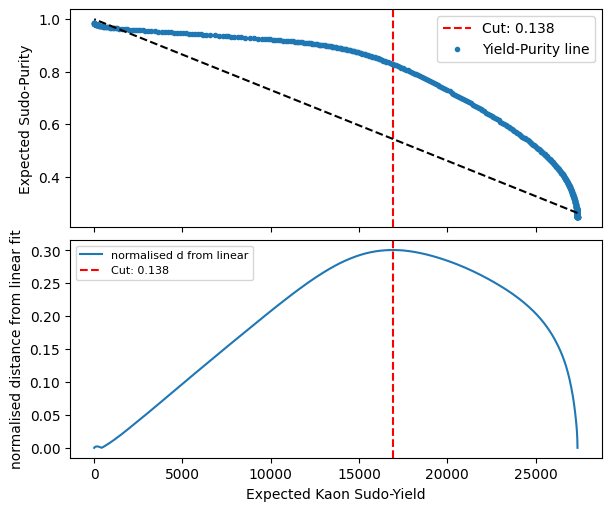

[]


In [23]:
# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []
prob_k=[]
prob_pi=[]
m_B_all=[]
m_B_all_uncertainties=[]
m_R_neutral_1=[]
m_R_neutral_1_uncertainties=[]
m_R_neutral_2=[]
m_R_neutral_2_uncertainties=[]
m_high_all=[]
m_low_all=[]
probabilities = []


    
# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
# Set to -1 to run over all events. 
# It is recommended to keep the number of events limited while developing the analysis.
MAX_EVENTS = 50000

# Select which set of input data is to be analysed. Uncomment exactly one line
# trees = [events_sim['PhaseSpaceTree']]                       # Simulation
# trees = [events_down['DecayTree']]                          # Magnet down data
#trees = [events_up['DecayTree']]                             # Magnet up data
trees = [events_down['DecayTree'],events_up['DecayTree']]   # Magnet down+up data

# This loop goes over the trees to be analysed
for tree in trees:
    # This outer loop is a technical loop of uproot over chunks of events
#    for data in tree.iterate(['H*_P[XYZ]','H*_Charge','H*_Prob*','H*_isMuon'], library='np'): #not working ...
    for data in tree.iterate( library='np' ):
        # As Python can handle calculations with arrays, we can calculate derived quantities here
        pT_H1 = np.sqrt(data['H1_PX']**2+data['H1_PY']**2)
        pT_H2 = np.sqrt(data['H2_PX']**2+data['H2_PY']**2)
        pT_H3 = np.sqrt(data['H3_PX']**2+data['H3_PY']**2)
        

        # B_meson invariant mass


        m_k=493.667
        print(len(data['H2_ProbK']))
        mask1=(Selection_Alg(original_probabilties=data['H1_ProbK'],plotting=False)[0])
        mask2=(Selection_Alg(original_probabilties=data['H2_ProbK'],plotting=False)[0])
        mask3=(Selection_Alg(original_probabilties=data['H3_ProbK'],plotting=False)[0])

        # mask1=np.full(len(data['H1_ProbK']),True)
        # mask2=np.full(len(data['H2_ProbK']),True)
        # mask3=np.full(len(data['H2_ProbK']),True)

        # mask1=data['H1_ProbK']>0.9
        # mask2=data['H2_ProbK']>0.9
        # mask3=data['H2_ProbK']>0.9

        m_B=B_meson_invariant_mass(data,m_k,mask1,mask2,mask3)
        # m_B_uncertainty=mass_uncertainties_B(m_k,data,m_B)
        m_B_all.append(m_B)
        # m_B_all_uncertainties.append(m_B_uncertainty)
        
        

        # neutral particles invariant mass
        # data_neutral_mask=(data['H1_Charge'][mask1 & mask2 & mask3] + data['H2_Charge'][mask1 & mask2 & mask3] + data['H3_Charge'][mask1 & mask2 & mask3]).abs()==1
        data_neutral_mask=np.abs(data['H1_Charge'] + data['H2_Charge'] + data['H3_Charge'])==1
        event_mask=data_neutral_mask & mask1 & mask2 & mask3
        H1_different_mask=event_mask & (data['H1_Charge']!=data['H2_Charge']) & (data['H1_Charge']!=data['H3_Charge'])
        H2_different_mask=event_mask & (data['H2_Charge']!=data['H1_Charge']) & (data['H2_Charge']!=data['H3_Charge'])
        H3_different_mask=event_mask & (data['H3_Charge']!=data['H2_Charge']) & (data['H3_Charge']!=data['H1_Charge'])

        m12=calculating_neutral_particle_invariant_mass(data,'H1','H2',m_k)
        m13=calculating_neutral_particle_invariant_mass(data,'H1','H3',m_k)
        m23=calculating_neutral_particle_invariant_mass(data,'H2','H3',m_k)
        
        # sigma12 = neutral_mass_uncertainty(data,'H1','H2',m_k)
        # sigma13 = neutral_mass_uncertainty(data,'H1','H3',m_k)
        # sigma23 = neutral_mass_uncertainty(data,'H2','H3',m_k)

        m_R_neutral_1.append((H1_different_mask*m12 + H2_different_mask*m12 + H3_different_mask*m13)[event_mask])
        m_R_neutral_2.append((H1_different_mask*m13 + H2_different_mask*m23 + H3_different_mask*m23)[event_mask])
        # m_R_neutral_1_uncertainties.append(
        #     np.where(H1_different_mask, sigma12,
        #     np.where(H2_different_mask, sigma12,
        #     np.where(H3_different_mask, sigma13, np.nan)))
        #     [event_mask]
        #     )
        # m_R_neutral_2_uncertainties.append((H1_different_mask*sigma13 + H2_different_mask*sigma23 + H3_different_mask*sigma23)[event_mask])

        # This loop will go over individual events
        for i in range(0,len(data['H1_PZ'])):
            event_counter += 1
            if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
            if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
            # Decide here which events to analyse
            if (data['H1_PZ'][i] < 0) or (data['H2_PZ'][i] < 0) or (data['H3_PZ'][i] < 0): continue
            if (data['H1_isMuon'][i]==1) or (data['H2_isMuon'][i]==1) or (data['H3_isMuon'][i]==1): continue
            # Fill arrays of events to be plotted and analysed further below
            # Adding values for all three hadrons to the same variable here
            pT.append(pT_H1[i])
            pT.append(pT_H2[i])
            pT.append(pT_H3[i])
            pX.append(data['H1_PX'][i])
            pX.append(data['H2_PX'][i])
            pX.append(data['H3_PX'][i])
            pY.append(data['H1_PY'][i])
            pY.append(data['H2_PY'][i])
            pY.append(data['H3_PY'][i])
            pZ.append(data['H1_PZ'][i])
            pZ.append(data['H2_PZ'][i])
            pZ.append(data['H3_PZ'][i])

            prob_k.append(data['H1_ProbK'][i])
            prob_pi.append(data['H1_ProbPi'][i])
            prob_k.append(data['H2_ProbK'][i])
            prob_pi.append(data['H2_ProbPi'][i])
            prob_k.append(data['H3_ProbK'][i])
            prob_pi.append(data['H3_ProbPi'][i])
            probabilities.append(data['H1_ProbK'][i]/(data['H1_ProbK'][i]+data['H1_ProbPi'][i]))
            probabilities.append(data['H2_ProbK'][i]/(data['H2_ProbK'][i]+data['H2_ProbPi'][i]))
            probabilities.append(data['H3_ProbK'][i]/(data['H3_ProbK'][i]+data['H3_ProbPi'][i]))
print('Read {:d} events'.format(event_counter))
print(pT[0])
prob_k=np.array(prob_k)
prob_pi=np.array(prob_pi)
pT=np.array(pT)
pX=np.array(pX)
pY=np.array(pY)
pZ=np.array(pZ)





cut,knee_cut=Selection_Alg(original_probabilties=probabilities,plotting=True)
pT=pT[cut]
pX=pX[cut]
pY=pY[cut]
pZ=pZ[cut]
prob_k=prob_k[cut]
prob_pi=prob_pi[cut]

m_B_all=np.concatenate(m_B_all)

three_body_mask=(m_B_all>=5250) & (m_B_all<=5300)
m_R_neutral_1=np.concatenate(m_R_neutral_1)[three_body_mask]
m_R_neutral_2=np.concatenate(m_R_neutral_2)[three_body_mask]



m_high_all=np.maximum(m_R_neutral_1,m_R_neutral_2)
m_low_all=np.minimum(m_R_neutral_1,m_R_neutral_2)

chi_meson_removal_mask_1 = (~((m_high_all > 3404.21) & (m_high_all < 3425.21))) & \
                           ((m_high_all < 1864.84 - 1e-3) | (m_high_all > 1864.84 + 1e-3))

chi_meson_removal_mask_2 = (~((m_low_all > 3404.21) & (m_low_all < 3425.21))) & \
                           ((m_low_all < 1864.84 - 1e-3) | (m_low_all > 1864.84 + 1e-3))


m_high_all=m_high_all[chi_meson_removal_mask_1]
m_low_all=m_low_all[chi_meson_removal_mask_2]

print(m_R_neutral_1_uncertainties)





### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 1D histogram


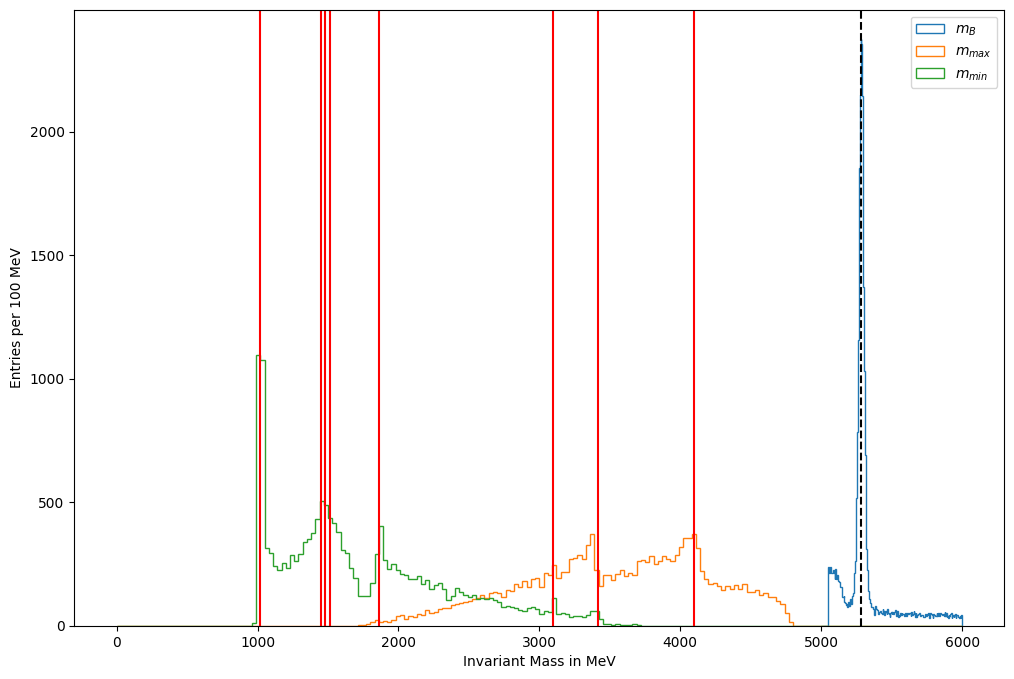

In [24]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_m_B,bins_m_B,patches_m_B = ax.hist(m_B_all, bins = 200, range = [5000, 6000],histtype='step',label='$m_{B}$')
values_m_R12,bins_m_R12,patches_m_R12 = ax.hist(m_high_all, bins = 200, range = [0, 6000],histtype='step',label='$m_{max}$')
values_m_R13,bins_m_R13,patches_m_R13 = ax.hist(m_low_all, bins = 200, range = [0, 6000],histtype='step',label='$m_{min}$')

# phi strange-antistrange
ax.axvline(1019.461,color='red')
#f'_2 - mainly strange-anti-strange with some up-anti-up and down-antidown
ax.axvline(1512,color='red')
#eta - even mix of up-anti-up, down-antidown and strange-antistrange
ax.axvline(1475,color='red')
#rho - mainly up-anti-up and down-antidown
ax.axvline(1450,color='red')
#D_0 charm antiup
ax.axvline(1864.84,color='red')

# 2-3 GeV region is mainly comprised of excited light meson states.

#J/psi charm-anticharm
ax.axvline(3096.9,color='red')
#chi_c0 charm-anticharm
ax.axvline(3414.71,color='red')
# Charmonium (excited) states) and tetra quark candidates in the region of 4GeV - 4.5 GeV
ax.axvline(4100,color='red')

#slight peak before could be from particle misidentification from choosing the wrong kaon candidate.

# B meson
ax.axvline(5279,color='k',linestyle='--')


# peaks,_=scipy.signal.find_peaks(values_m_B,height=25)
# widths,width_heights,pos_left,pos_right=scipy.signal.peak_widths(values_m_B,peaks,rel_height=0.5)
# int_pos_right=int(np.floor(pos_right[0]))
# int_pos_left=int(np.floor(pos_left[0]))
# print(bins_m_B[peaks],values_m_B[peaks])
# print((m_B.max()-m_B.min())/2000)
# ax.scatter(bins_m_B[peaks],values_m_B[peaks],color='red')
# ax.hlines(0.5*values_m_B[peaks],bins_m_B[int_pos_left],bins_m_B[int_pos_right],color='red')
#ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax.set_xlabel('Invariant Mass in MeV')
ax.set_ylabel('Entries per 100 MeV')
ax.legend()
plt.savefig('./plots/invariant_masses_yield_cuts.png')



Plotting 1D histogram
Plotting 2D histogram


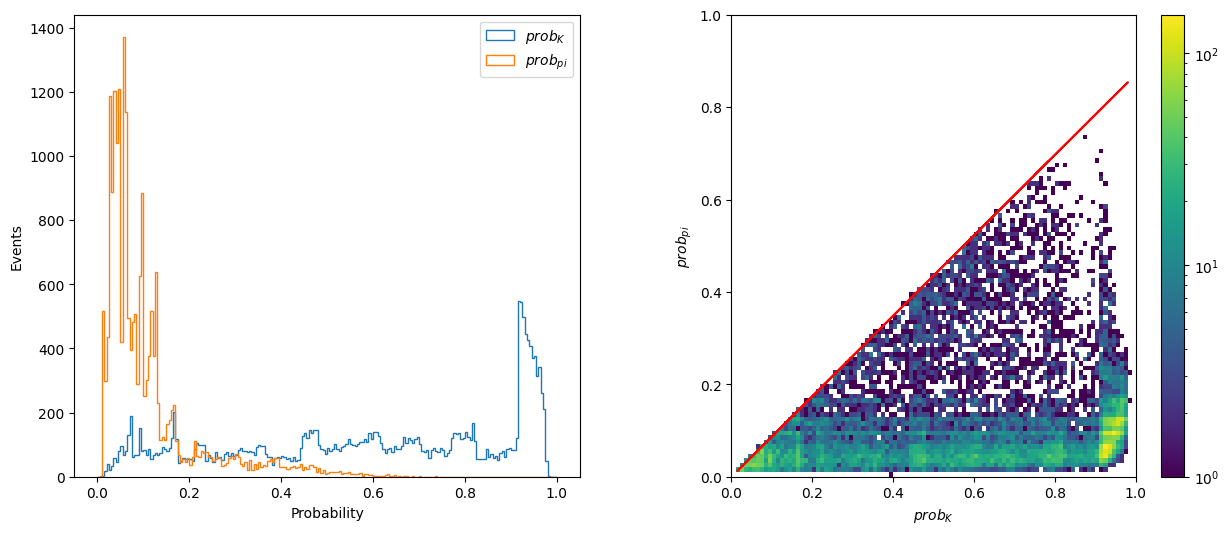

In [14]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_prob_k,bins_prob_k,patches_prob_k = ax[0].hist(prob_k, bins = 200, range = [0, 1],histtype='step',label='$prob_{K}$')
values_prob_pi,bins_prob_pi,patches_prob_pi = ax[0].hist(prob_pi, bins = 200, range = [0, 1],histtype='step',label='$prob_{pi}$')

#ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Probability')
ax[0].set_ylabel('Events')
ax[0].legend()

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(prob_k,prob_pi, bins = [100,100], range = [[0,1],[0,1]],norm=colors.LogNorm())
ax[1].plot(prob_k,(np.exp(-knee_cut))*prob_k,color='red')
ax[1].set_xlabel('$prob_{K}$')
ax[1].set_ylabel('$prob_{pi}$')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
# plt.savefig('prob_pi_prob_k.png')


c:\Users\georg\OneDrive\Documents\Matter-AntimatterLab\UoM_MatterAntimatterLab\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:592: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35897.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test: stat = 0.7288, p-value = 3.3093013455118213e-115
Data is NOT Gaussian (reject H0)


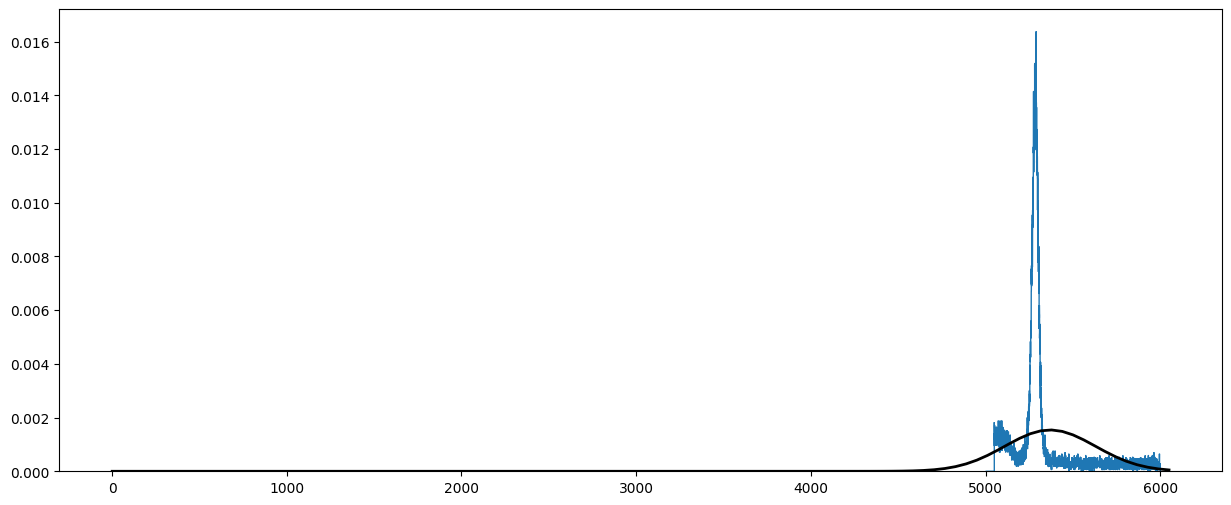

In [15]:
from scipy import stats
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))


x_k=prob_k[prob_k>0.9]
values_prob_k,bins_prob_k,patches_prob_k = ax.hist(m_B_all, bins = 2000, range = [5000, 6000],histtype='step',density=True,label='$m_{B}$')
mu, std = stats.norm.fit(m_B_all) 


# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(0.9, xmax, 100)
p = stats.norm.pdf(x, mu, std)

ax.plot(x, p, 'k', linewidth=2)


shapiro_stat, shapiro_p = stats.shapiro(m_B_all)
print(f"Shapiro-Wilk Test: stat = {shapiro_stat:.4f}, p-value = {shapiro_p}")
if shapiro_p > 0.05:
    print("Data looks Gaussian (fail to reject H0)")
else:
    print("Data is NOT Gaussian (reject H0)")

#print(np.histogram(x))
#shapiro_test=stats.shapiro(x)

# plt.savefig('testing_normal_distribution.png')


Plotting 1D histogram
[3.65475069e+03 3.19753266e-04]
Plotting 2D histogram


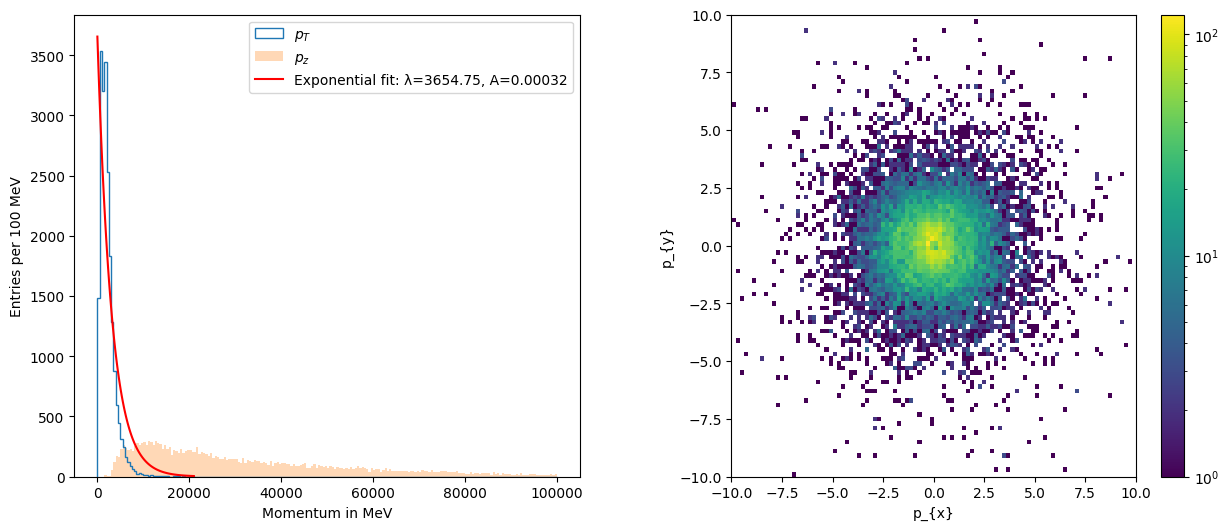

In [16]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')


def exponential(x,a,k):
    return a*np.exp(-k*x)

counts, bin_edges = np.histogram(pT, bins=200, range=[0, 100000], density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial amplitude guess: first bin count
a0 = max(counts)

# Initial lambda guess: 1 / mean of the data
k0 = 1.0 / np.mean(pT)

p0 = [a0, k0]
popt, pcov = curve_fit(exponential, bin_centers, counts, p0)
values_pT,bins_pT,patches_pT = ax[0].hist(pT, bins = 200, range = [0, 100000],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
print(popt)
x_fit = np.linspace(0, max(pT), 100)
ax[0].plot(x_fit, exponential(x_fit, popt[0],popt[1]), 'r-', label=f'Exponential fit: λ={popt[0]:.2f}, A={popt[1]:.5f}')


ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()


# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel('p_{x}')
ax[1].set_ylabel('p_{y}')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
# plt.savefig('pTpZ.png')





### Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

Fit results with chi2/ndf 69.54119416608617 / 20
Par 1: 74.120023 +/- 11.009382
Par 2: 55521.789389 +/- 3338.813018
Par 3: 1751.947554 +/- 33.536892


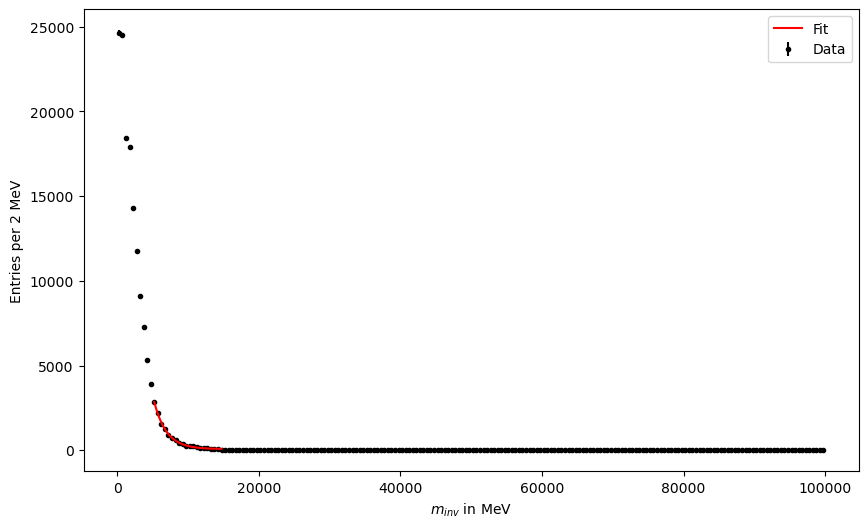

In [9]:
# decaying exponential function
def exponential(x, norm, decay):
    xoffset = 0 # this is a technical parameter, which can be used to move the position at which the function evaluates to "norm"
    return np.array( norm * np.exp(-(x-xoffset)/decay) )

# constant function
def constant(x, norm):
    return np.array( norm )

# fit function combining two individual functions
def fit_function(x, norm, normE, decay):
    return np.array( constant(x, norm) + exponential(x, normE, decay) )

def fit_data(bins, values, minX, maxX, p0):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays

    # reduce range to fit only part of curve
    bin_centres_red = [] 
    values_red = []
    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: continue
        bin_centres_red.append(c)
        values_red.append(v)

    # execute the fit with starting values as given in p0
    coeff_fit,cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0) # fit
    
    # evaluate chi2
    fit_vals = [fit_function(x,coeff_fit[0],coeff_fit[1],coeff_fit[2]) for x in bin_centres_red]
    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ), 
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    chi2 = np.sum( chi2parts )
    
    return coeff_fit,cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

def plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2])
    a.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

    # plot decoration
    a.legend()
    a.set_xlabel('$m_{inv}$ in MeV')
    a.set_ylabel('Entries per 2 MeV')
    plt.savefig(fname)

coeff_pT,cov_pT, bin_centres_pT, bin_centres_red_pT, chi2_pT, ndf_pT = fit_data( bins_pT, values_pT, 5000, 15000, [100,10000,10000] )

print_results(coeff_pT,cov_pT, chi2_pT, ndf_pT)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plot_results(ax,bin_centres_pT,bin_centres_red_pT,values_pT,coeff_pT,'fit_pT.pdf')

### Manipulation of 2D histograms

The following is an example code to demonstrate manipulation of the content of 2D histograms. It first produces two dummy histograms before working out the bin centres, subtracting the histogram contents, and finally plotting. The subtraction bit can of course be replaced by more complex operations as well.

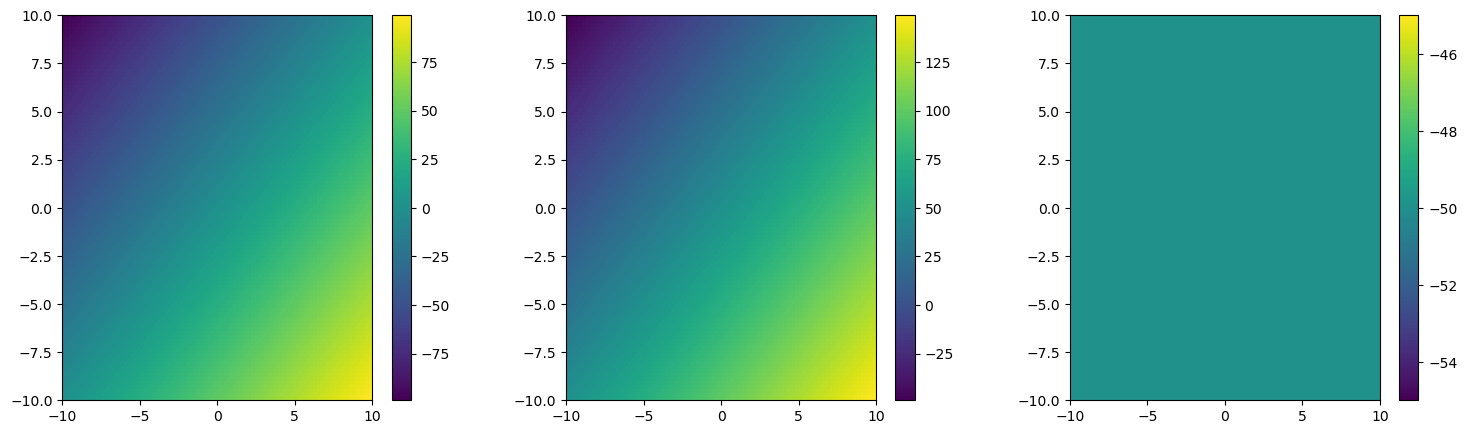

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

### ignore this bit and replace by however you produce your two 2D histograms to be subtracted ###
xvalues = []
yvalues = []
weights1 = []
weights2 = []
for x in range(100):
    for y in range(100):
        xvalues.append(-10+x/5.+0.1) # bin centre for x
        yvalues.append(-10+y/5.+0.1) # bin centre for y
        weights1.append((x-y))       # weights for histo1, this would be filled automatically
        weights2.append((x-y)+50)    # weights for histo2
h2d1 = ax[0].hist2d(xvalues,yvalues,weights=weights1,bins = [100,100], range = [[-10,10],[-10,10]])        
h2d2 = ax[1].hist2d(xvalues,yvalues,weights=weights2,bins = [100,100], range = [[-10,10],[-10,10]])
### end ignoring here :) ###

# first calculate the bin centres from the bin boundaries of the hist2d object
xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
wsub = np.subtract(w1,w2) # subtract bin content of two histograms

# produce the new histogram
h2d3 = ax[2].hist2d(xcentres,ycentres,weights=wsub, bins = [h2d1[1],h2d1[2]]) # recycle the binning from above

# plot the lot
fig.colorbar(h2d1[3],ax=ax[0]) # let's add the colour scale for histo 1
fig.colorbar(h2d2[3],ax=ax[1]) # let's add the colour scale for histo 2
fig.colorbar(h2d3[3],ax=ax[2]) # let's add the colour scale for histo 3